In [105]:
import  numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix,classification_report
import seaborn as sns




In [77]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

DATA VISUALIZATION

In [78]:
def show_image(img: np.ndarray, ax: plt.Axes=None, title: str=None) -> None:
    """ Show array as image """
    if ax is None:
        ax = plt.subplot(111)
    ax.imshow(img)
    ax.axis("off")
    if title:
        ax.set_title(title)

LABELS OF DATASET

In [79]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']


In [80]:
#Visualization
def get_rgb_image(file_var):
    R = file_var[:, :1024].reshape(-1, 32, 32)
    G = file_var[:, 1024:2048].reshape(-1, 32, 32)
    B = file_var[:, 2048:].reshape(-1, 32, 32)
    rgb = np.stack((R, G, B), axis=-1)
    return rgb 

LOADING OF BATCH FILE

In [81]:
def process_batch(file_path):
    data = unpickle(file_path)
    uncleanedX = data[b'data']
    x = get_rgb_image(uncleanedX)
    y = data[b'labels']
    return x, y

LOADING OF BATCHES

In [82]:
#Load Batches
data_dir = "../data/cifar-10-batches-py/"
files = [i for i in Path(data_dir).glob("data_batch*")]
files


[WindowsPath('../data/cifar-10-batches-py/data_batch_1'),
 WindowsPath('../data/cifar-10-batches-py/data_batch_2'),
 WindowsPath('../data/cifar-10-batches-py/data_batch_3'),
 WindowsPath('../data/cifar-10-batches-py/data_batch_4'),
 WindowsPath('../data/cifar-10-batches-py/data_batch_5')]

TRAINING SET

In [83]:
x, y = [], []
for i in files:
    xi, yi = process_batch(i)
    x.append(xi)
    y.append(yi)

X_train = np.concatenate(x)
y_train = np.concatenate(y)
X_val = np.concatenate(x)
y_val = np.concatenate(y)
X_train.shape
X_val.shape


    

(50000, 32, 32, 3)

TEST SET

In [84]:
X_test, y_test = process_batch("../data/cifar-10-batches-py/test_batch")
y_test = np.array(y_test)
y_test.shape

(10000,)

NORMALIZATION

In [85]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [86]:
#
# y_train = y_train.astype(int)
#y_test = y_test.astype(int)

SPLITTING OF TRAIN SET

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) 
X_train.shape, X_val.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000,))

DATA AUGMENTATION

In [88]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

BUILDING AND TRAINING OF MODEL

In [89]:
inputs = tf.keras.Input(shape=(32,32,3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3,3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)


x = layers.Conv2D(64, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)



x = layers.Conv2D(128, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)  

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))(x)


model = models.Model(inputs, outputs)


# Summary
model.summary()
print("Total params:", model.count_params())



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,466 (2.10 MB)

 Trainable params: 551,018 (2.10 MB)

 Non-trainable params: 448 (1.75 KB)

Total params: 551466


In [90]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',   # watch validation loss
    patience=5,           # stop if no improvement for 3 epochs
    restore_best_weights=True,
    verbose = 1
)

LEARNING RATE

In [91]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

Saves the best Model

In [92]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose = 1
    
)

In [100]:
history = model.fit(
    X_train, y_train,
     batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
     callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8370 - loss: 0.6562
Epoch 1: val_loss did not improve from 0.78093
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 65ms/step - accuracy: 0.8357 - loss: 0.6615 - val_accuracy: 0.7855 - val_loss: 0.8504 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8628 - loss: 0.5860
Epoch 2: val_loss improved from 0.78093 to 0.77630, saving model to best_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.8584 - loss: 0.5970 - val_accuracy: 0.8104 - val_loss: 0.7763 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8752 - loss: 0.5493
Epoch 3: val_loss did not improve from 0.77630
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.8708 - loss: 0.5621 - val_accuracy: 0.8020 - val_loss: 0.8248 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8863 - loss: 0.5172
Epoch 4: val_loss 

Train And Validation Losses

<Axes: >

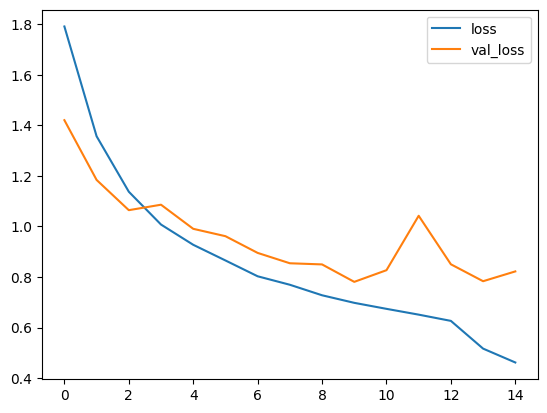

In [94]:
df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()

OVERALL ACCURACY OF TEST SET

In [101]:
y_pred_probs = model.predict(X_test)
y_preds = np.argmax(y_pred_probs, axis=1)
overall_accuracy = accuracy_score(y_preds,y_test)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Overall Accuracy: 0.8290


In [96]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

print(classification_report(y_test, y_preds, target_names=labels))

f1 = f1_score(y_test, y_preds, average='weighted')
print(f" F1 Score: {f1:.4f}")


              precision    recall  f1-score   support

    airplane       0.81      0.81      0.81      1000
  automobile       0.93      0.90      0.91      1000
        bird       0.68      0.70      0.69      1000
         cat       0.61      0.66      0.63      1000
        deer       0.77      0.75      0.76      1000
         dog       0.79      0.61      0.69      1000
        frog       0.78      0.90      0.83      1000
       horse       0.87      0.83      0.85      1000
        ship       0.87      0.91      0.89      1000
       truck       0.88      0.88      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

 F1 Score: 0.7951


CONFUSION MATRIX

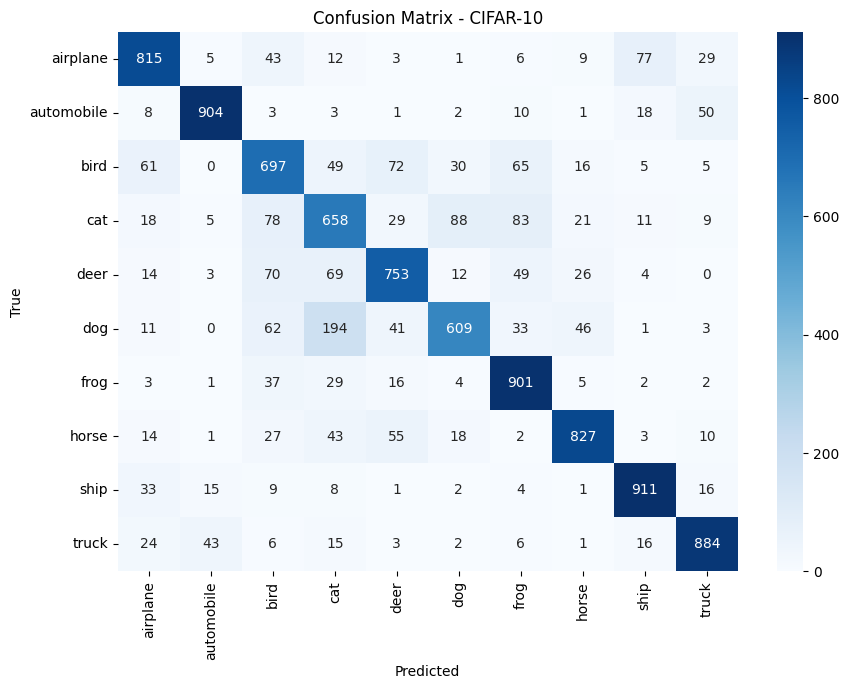

In [97]:
# Generate Confusion Matrix
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_test, y_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-10")
plt.show()


LABELS/CLASS ACCURACY

Accuracy for class truck: 88.40%


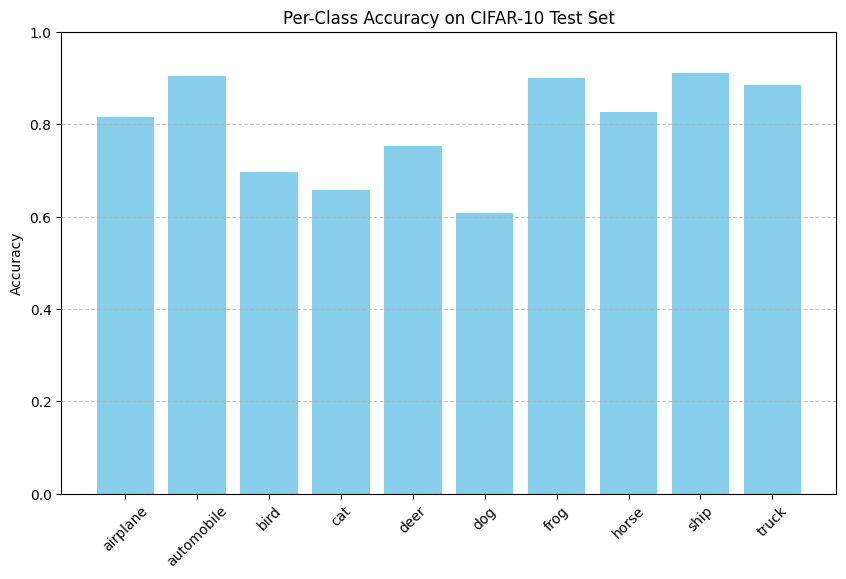

In [98]:
# loop through each class and calculate accuracy
for i, label_name in enumerate(labels):
    # get indexes of samples that belong to class i
    idxs = np.where(y_test == i)[0]
    # compute accuracy for this class
acc = accuracy_score(y_test[idxs], y_preds[idxs])
print(f"Accuracy for class {label_name}: {acc*100:.2f}%")

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,6))
plt.bar(labels, per_class_acc, color='skyblue')
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy on CIFAR-10 Test Set")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

INCORRECTLY CLASSIFIED IMAGES

Total misclassified samples: 2041


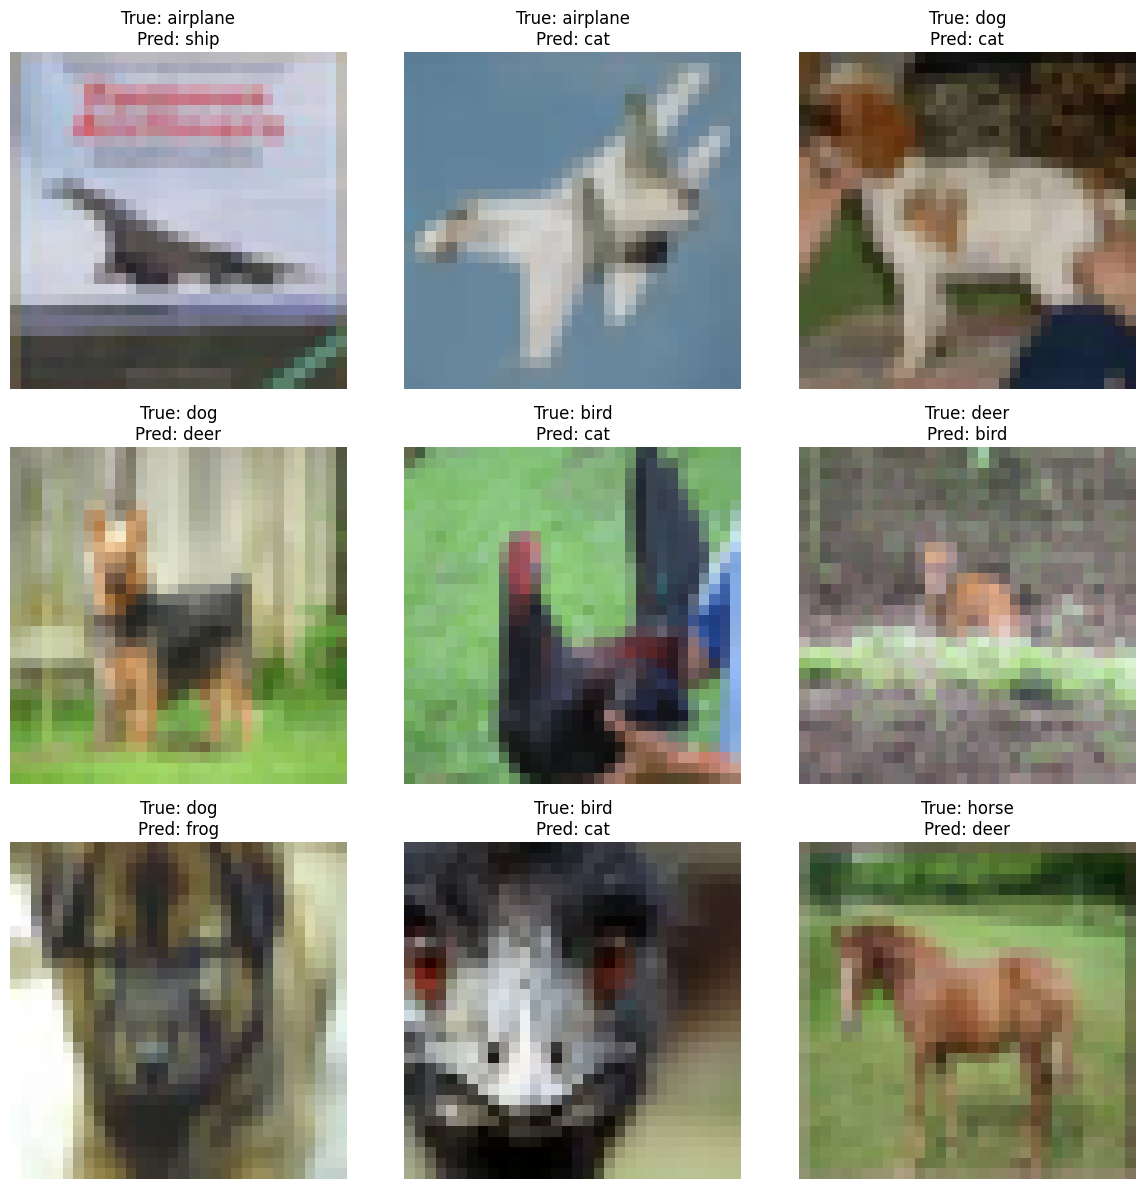

In [99]:
misclassified_idx = np.where(y_preds != y_test)[0]
print("Total misclassified samples:", len(misclassified_idx))

# Show first 9 misclassified samples
plt.figure(figsize=(12,12))

for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx])  # show image
    plt.title(f"True: {labels[y_test[idx]]}\nPred: {labels[y_preds[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()